In [1]:
# Clear memory
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import ipywidgets
ipywidgets.Widget.close_all()

import SimpleITK
import datetime
import gc # Garbage collected
import numpy as np
import sys, os
import time
import tifffile
import matplotlib.pyplot as plt
import scipy
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askopenfilenames, askdirectory
import torch
import skimage
from skimage import measure

this_path = os.getcwd()
print(this_path)


import h5py
# import File
from scripts import *
import wrapper_ASTRA


/global/u2/e/eboigne/tomoTools_als832/tomoTools


In [3]:
path_save = '/global/cfs/cdirs/als/users/eboigne/2022_wood/'
case = 'run23_walnut_lowHeat'
case = 'run21_oak_lowHeat'
case = 'run26_birch_highHeat'

In [5]:
##check registration

ind_slice = 250

list_cases = sorted([e for e in os.listdir(path_save+case) if not 'probe' in e and not '.tif' in e])
print(list_cases)

slices = []
for ind_case, this_case in enumerate(list_cases[:-1]):
    slices.append(File(path_save+case+'/'+this_case+'/b_movingRegisteredToStatic/').read(ind_slice))
    print(ind_case, this_case)

slices = np.array(slices)
print(slices.shape)
File(path_save+case+'/probe_slice_'+str(ind_slice).zfill(4)).saveTiffStack(slices)

['01', '02', '03', '04', '05', '06', '07a', '07b', '08a', '08b', '09a', '09b', '10a', '10b', '11a', '11b', '12a', '12b', '13a', '13b', '14a', '14b', '15a', '15b', '16a', '16b', '17a', '17b', '18a', '18b', '19a', '19b', '20a', '20b', '21a', '21b', '22a', '22b', '23a', '23b', '24a', '24b', '25a', '25b', '26a', '26b', '27-post', '28-post', '29-post', '30-post', '31-post', '32-post']
0 01
1 02
2 03
3 04
4 05
5 06
6 07a
7 07b
8 08a
9 08b
10 09a
11 09b
12 10a
13 10b
14 11a
15 11b
16 12a
17 12b
18 13a
19 13b
20 14a
21 14b
22 15a
23 15b
24 16a
25 16b
26 17a
27 17b
28 18a
29 18b
30 19a
31 19b
32 20a
33 20b
34 21a
35 21b
36 22a
37 22b
38 23a
39 23b
40 24a
41 24b
42 25a
43 25b
44 26a
45 26b
46 27-post
47 28-post
48 29-post
49 30-post
50 31-post
(51, 1280, 1280)


In [5]:
print(case)

run23_walnut_lowHeat


In [4]:
scan_to_test = '17a'

# Load data
tic = time.time()
data = File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic/').readAll()
print('Loading data took: '+str(time.time()-tic))
print(data.shape)


Loading data took: 38.8473801612854
(698, 1280, 1280)


In [5]:
threshold = 0.05 # Linear attenuation threshold [/cm], gas to wood 
threshold_needle = 4.0 # Linear attenuation threshold [/cm]
mask_growth_needle = 10 # Grow the mask obtained using threshold_needle with this amount of pixels
mask_enclosing_circle = tifffile.imread(path_save+case+'/maskEnclosingCircle.tif') > 0

bin_factor_dilatation = 1 # Binning before smoothing, as an option to speed things up for large kernels
filter_half_width = 3 # After binning (equal to sigma for gaussian filter)

# kernel = custom_3d_kernel_sphere(filter_half_width)
kernel = custom_3d_gaussian_filter(filter_half_width) 
# filter_half_width = (kernel.shape[0]-1)/2

tic = time.time()
if bin_factor_dilatation > 1:
    data_smoothed = fast_pytorch_bin_3d(data,bin_factor_dilatation, chunk_size = 71)
else:
    data_smoothed = data

print(data_smoothed.shape)
data_smoothed = apply_3d_image_processing_on_subvolumes(data_smoothed, fast_pytorch_convolution, kernel_array = kernel, chunk_size_max = (500, 500, 500), overlap = 3*filter_half_width)
print(data_smoothed.shape)

if bin_factor_dilatation > 1:
    data_smoothed = skimage.transform.rescale(data_smoothed, bin_factor_dilatation, multichannel=False)
print('Smoothing data took: '+str(time.time()-tic))

# Save smoothed data
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_smoothed_bin'+str(bin_factor_dilatation)+'x_FHW_'+str(filter_half_width)).saveTiffStack(data_smoothed)

mask_needle = data_smoothed > threshold_needle
mask_needle = apply_3d_image_processing_on_subvolumes(mask_needle, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = mask_growth_needle, radius = mask_growth_needle)
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskNeedle').saveTiffStack(mask_needle, type = 'bool')

mask_solid = data_smoothed > threshold
mask_solid[mask_needle] = False
for ind, slice in enumerate(mask_solid):
    slice[~mask_enclosing_circle] = False
    mask_solid[ind] = slice
    if ind % 100 == 0:
        print(ind)

(698, 1280, 1280)
	 Processing 18 chunks of size [349 426 426] .................. Done
(698, 1280, 1280)
Smoothing data took: 24.39327311515808
	 Processing 18 chunks of size [349 426 426] .................. Done
0
100
200
300
400
500
600


In [47]:
#pull time 

path_save = '/global/cfs/cdirs/als/users/eboigne/2022_wood/'
case = 'run24_birch_lowHeat'
scan_to_test = '17a'
run = '24_SampleB2'

list_cases_int = sorted([e for e in os.listdir(path_save) if '.h5' in e and run in e])
list_cases_eval = sorted([e for e in os.listdir(path_save+case) if not 'probe' in e and not '.tif' in e])
c=[]
for this_case in enumerate(list_cases_int[:]):
    c.append(this_case[1][35:37])
t=[]
for this_case in enumerate(c[:-1]):
    if str(this_case[1]) == str(list_cases_eval[this_case[0]]):
        print('c')
        cc = list_cases_int[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts = int(h)*3600+int(m)*60+int(s)
        print(ts)
        t.append(ts) #c
    else:
        print('a/b')
        cc = list_cases_int[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts0 = int(h)*3600+int(m)*60+int(s)
        t.append(ts0) #a
        print(ts0)
        ts1 = 26.26 + ts0
        t.append(ts1) #b
        print(ts1)
t = [x - t[0] for x in t]


c
62666
c
62972
c
63291
c
63812
c
64069
c
64249
c
64434
a/b
64616
64642.26
a/b
64813
64839.26
a/b
65005
65031.26
a/b
65187
65213.26
a/b
65369
65395.26
a/b
65553
65579.26
a/b
65736
65762.26
a/b
65932
65958.26
a/b
66121
66147.26
a/b
66304
66330.26
a/b
66488
66514.26
a/b
66673
66699.26
a/b
66864
66890.26
a/b
67049
67075.26
a/b
67247
67273.26
a/b
67552
67578.26


In [41]:
# pull time 

path_save = '/global/cfs/cdirs/als/users/eboigne/2022_wood/'
run = '24_SampleB2'

list_cases = sorted([e for e in os.listdir(path_save) if '.h5' in e and run in e])
t = []
for this_case in enumerate(list_cases[:]):
    c = this_case[1][9:15]
    h = c[0:2]
    m = c[2:4]
    s = c[4:]
    ts = int(h)*3600+int(m)*60+int(s)
    t.append(ts)
t = [x - t[0] for x in t]

print(t)

[0, 306, 625, 1146, 1403, 1583, 1768, 1950, 2147, 2339, 2521, 2703, 2887, 3070, 3266, 3455, 3638, 3822, 4007, 4198, 4383, 4581, 4886, 5194]


In [ ]:
def time_sec(path_save, run):
    

In [14]:
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskNeedle').saveTiffStack(mask_needle, type = 'bool')

In [6]:
ind_bottom = 100
ind_top = 610

mask_solid[:ind_bottom] = False
mask_solid[ind_top:] = False

	 Processing 18 chunks of size [349 426 426] .................. Done
	 Processing 18 chunks of size [349 426 426] .................. Done
Closing data took: 151.57955241203308


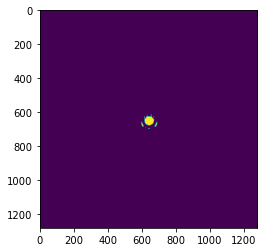

In [7]:
slice = mask_solid[ind_top-1]
plt.imshow(slice)

filter_half_width = 12
structure = custom_3d_kernel_sphere(filter_half_width)

mask_solid_dilated = apply_3d_image_processing_on_subvolumes(mask_solid, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = filter_half_width, radius = filter_half_width)
# print('1')
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolidDilated').saveTiffStack(mask_solid_dilated, type = 'bool')
mask_solid_closed = ~apply_3d_image_processing_on_subvolumes(~mask_solid_dilated, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = filter_half_width, radius = filter_half_width)
print('Closing data took: '+str(time.time()-tic))
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolidClosed').saveTiffStack(mask_solid_closed, type = 'bool')

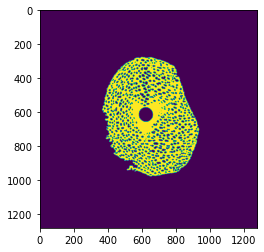

In [20]:
slice = mask_solid[200]
plt.imshow(slice)

In [10]:
# scipy.ndimage.binary_fill_holes()

In [21]:
#save open pore solid 
File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolid').saveTiffStack(mask_solid, type = 'bool')

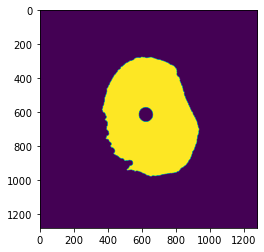

In [18]:
# calculate 



# closed_porosity = mask_solid[mask_solid == mask_solid_closed] = False
# File(path_save+case+'/'+scan_to_test+'/b_closed_porosity').saveTiffStack(closed_porosity, type = 'bool')
mask_solid = mask_solid.astype(np.uint8)
mask_solid_closed = mask_solid_closed.astype(np.uint8)

closed_porosity = mask_solid_closed - mask_solid

num = 200
# plt.imshow(closed_porosity[num])
# plt.imshow(mask_solid_close[num])
plt.imshow(mask_solid_closed[num])



In [22]:
################################################
tic = time.time()
lab = measure.label(~mask_solid)
print('Particle identification took: '+str(time.time()-tic))

Particle identification took: 15.05562710762024


In [23]:
tic = time.time()
File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskSolid_particleLabels').saveTiffStack(lab, type = 'bool')
print('label save took: '+str(time.time()-tic))

In [57]:
tic = time.time()
properties = measure.regionprops(lab)
print('Particle analysis took: '+str(time.time()-tic))

Particle analysis took: 9.605185270309448


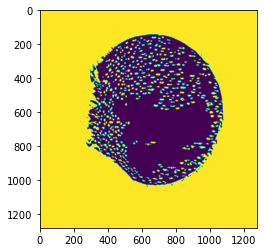

In [58]:
areas = [prop.area for prop in properties]

ind_max = np.argmax(areas)
prop_max_area = properties[ind_max]
mask_max_area = lab == prop_max_area.label

plt.imshow(mask_max_area[500], vmin = 0, vmax = 1)

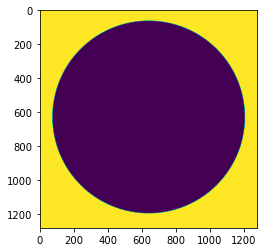

In [41]:
print(time.time())

1658280637.7989001
